<a href="https://colab.research.google.com/github/bhavepurva/Diabetes-detection/blob/main/diabetes_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#add zipped file to your drive, this code unzips the file in tmp directory
!unzip /content/drive/MyDrive/diab.zip -d /tmp/


Archive:  /content/drive/MyDrive/diab.zip
  inflating: /tmp/diabetes.csv       


In [ ]:
batch_size=25
epochs=500
shuffle=True
size_of_test_set=0.2
lr=0.001
classification_threshold=0.35
momentum_val=0.8
dropout_val=0.2

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix,precision_score, recall_score,roc_auc_score, accuracy_score

In [ ]:
#getting the data
data=pd.read_csv("/tmp/diabetes.csv")

#first five entries in dataframe
data.head()

#information about data such as null values and statistical data
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
#features and labels
y=data["Outcome"]
x=data.drop("Outcome",axis=1)

#determine null values or missing values
age=x["Age"]
preg=x["Pregnancies"]
x=x[["Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction"]].replace(0,np.nan)

x.head()
x.info()
x.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Glucose                   763 non-null    float64
 1   BloodPressure             733 non-null    float64
 2   SkinThickness             541 non-null    float64
 3   Insulin                   394 non-null    float64
 4   BMI                       757 non-null    float64
 5   DiabetesPedigreeFunction  768 non-null    float64
dtypes: float64(6)
memory usage: 36.1 KB


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction
count,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000
mean,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876
std,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329
min,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000
25%,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750
50%,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500
75%,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250
max,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000


In [ ]:
#imputer to impute mean value for each feature
imputer=SimpleImputer(strategy="mean")
imputer.fit(x)
print(imputer.statistics_)

#transforming feature data
X=imputer.transform(x)
x_transf=pd.DataFrame(X,columns=x.columns,index=x.index)
x_transf["Pregnancies"]=preg
x_transf["Age"]=age

#scaling values using minmaxscaler in range 0 to 1
scale=MinMaxScaler()
x_transf[x_transf.columns] = pd.DataFrame(scale.fit_transform(x_transf[x_transf.columns].values), columns=x_transf.columns, index=x_transf.index)
x_transf.head()

#creating a copy to obtain correlation after transformation
x_temp=x_transf.copy()
x_temp["Outcome"]=y
x_temp.head()
corr_matrix=x_temp.corr()
print(corr_matrix["Outcome"].sort_values(ascending=False))

[121.68676278  72.40518417  29.15341959 155.54822335  32.45746367
   0.4718763 ]
Outcome                     1.000000
Glucose                     0.492928
BMI                         0.311924
Age                         0.238356
Pregnancies                 0.221898
SkinThickness               0.215299
Insulin                     0.214411
DiabetesPedigreeFunction    0.173844
BloodPressure               0.166074
Name: Outcome, dtype: float64


In [ ]:
#split data into training and testing set, maintaining same ratio of outcome
x_train,x_test=train_test_split(x_transf,test_size=size_of_test_set,random_state=42,shuffle=shuffle)
y_train,y_test=train_test_split(y,test_size=size_of_test_set,random_state=42,shuffle=shuffle)

# len(y_train)
# len(y_test)
# x_train.head()
# y_train.head()

#outcome has same ratio for 1's and 0's
print(y_train.value_counts())
print(y_test.value_counts())

0    401
1    213
Name: Outcome, dtype: int64
0    99
1    55
Name: Outcome, dtype: int64


In [ ]:
#callback function to stop training once recall reaches 88%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epochs,logs={}):
    if logs.get("recall")>=0.88 and logs.get("auc")>=0.80 and epochs>=100:
      print("Reached recall of 88%")
      self.model.stop_training=True
callback=myCallback()

In [ ]:
#metrics for measuring accuracy
my_metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy',threshold=classification_threshold),
      tf.keras.metrics.Precision(name='precision',thresholds=classification_threshold),
      tf.keras.metrics.Recall(name="recall",thresholds=classification_threshold),
      tf.keras.metrics.AUC(num_thresholds=150, name='auc'),
]

#creating model
model=tf.keras.Sequential([
                           tf.keras.layers.Dense(16,input_shape=[len(x_train.keys())],activation="relu"),
                           tf.keras.layers.Dropout(dropout_val),
                           tf.keras.layers.Dense(16,activation="relu"),                          
                           tf.keras.layers.Dense(8,activation="relu"),
                           tf.keras.layers.Dense(1,activation="sigmoid")
])

#compiling the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr,momentum=momentum_val),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

#summary of layers involved in model created
model.summary()

#training the model
history = model.fit(x=x_train, y=y_train, batch_size=batch_size,epochs=epochs, shuffle=shuffle,callbacks=[callback])

#save model to load it later
model.save("my_model.h5")


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 16)                144       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
25/25 [==============================] - 1s 2ms/step - loss: 0.6616 - accuracy: 0.3811 - precision: 0.3306 - r

In [ ]:
#evaluate model against unseen data i.e. test set
model.evaluate(x = x_test, y = y_test, batch_size=batch_size)



7/7 [==============================] - 0s 3ms/step - loss: 0.5251 - accuracy: 0.7338 - precision: 0.5921 - recall: 0.8182 - auc: 0.8239


[0.5251131653785706,
 0.7337662577629089,
 0.5921052694320679,
 0.8181818127632141,
 0.8238751292228699]

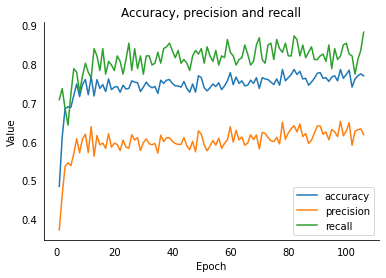

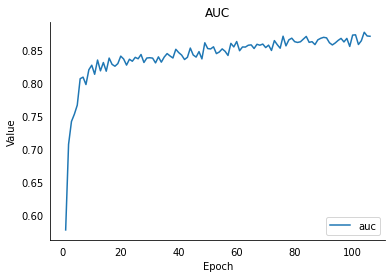

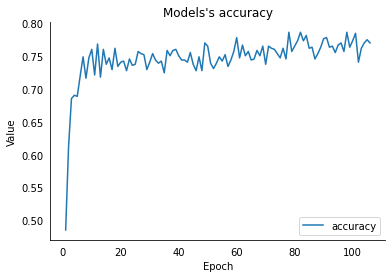

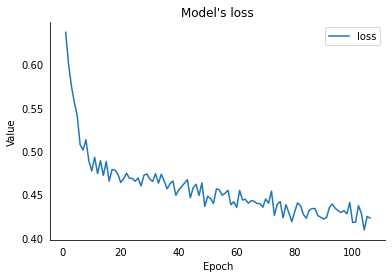

In [ ]:
epochs = history.epoch
hist = pd.DataFrame(history.history)

def plot_curve(epochs, hist, list_of_metrics,name_of_plot,legend_pos):
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")
  plt.title(name_of_plot)

  plt.tick_params(left=False,bottom=False)
  for pos in ['right', 'top']:
      plt.gca().spines[pos].set_visible(False)
  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)
  plt.legend(loc=legend_pos)

#graph for accuracy, precision and recall, recall being important parameter for diabetes detection
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot,"Accuracy, precision and recall","lower right")

#auc of roc
list_of_metrics_to_plot = ['auc'] 
plot_curve(epochs,hist,list_of_metrics_to_plot,"AUC","lower right")

list_of_metrics_to_plot=["accuracy"]
plot_curve(epochs,hist,list_of_metrics_to_plot,"Models's accuracy","lower right")

list_of_metrics_to_plot=["loss"]
plot_curve(epochs,hist,list_of_metrics_to_plot,"Model's loss","upper right")


In [ ]:
#the model saved before can be now directly loaded witout having to train it again
new_model=keras.models.load_model("my_model.h5")
new_model.summary()
acc_param=new_model.evaluate(x_test,y_test)
acc_param

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_294 (Dense)            (None, 16)                144       
_________________________________________________________________
dropout_63 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_295 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_296 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_297 (Dense)            (None, 1)                 9         
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________
5/5 [==============================] - 0s 3ms/step - loss: 0.5681 - accuracy: 0.7403 - precision: 0.6027 - recall: 0.8000

[0.5680758357048035,
 0.7402597665786743,
 0.6027397513389587,
 0.800000011920929,
 0.8022956848144531]

In [ ]:
#sgd
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(x_train, y_train)

y_test_pred=sgd_clf.predict(x_test)
print("Testing accuracy for sgd: "+str(accuracy_score(y_test, y_test_pred)))

cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)
print("Training precision for sgd: "+str(precision_score(y_train, y_train_pred)))
print("Training recall for sgd: "+str(recall_score(y_train, y_train_pred)))

cross_val_score(sgd_clf, x_test, y_test, cv=3, scoring="accuracy")
y_test_pred = cross_val_predict(sgd_clf, x_test, y_test, cv=3)
confusion_matrix(y_test, y_test_pred)
print("Testing precision for sgd: "+str(precision_score(y_test, y_test_pred)))
print("Testing recall for sgd: "+str(recall_score(y_test, y_test_pred)))

y_scores = cross_val_predict(sgd_clf, x_train, y_train, cv=3,method="decision_function")
print("Training auc for sgd: "+str(roc_auc_score(y_train, y_scores)))

y_scores = cross_val_predict(sgd_clf, x_test, y_test, cv=3,method="decision_function")
print("Testing auc for sgd: "+str(roc_auc_score(y_test, y_scores)))



#knn
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(x_train, y_train)

y_test_pred=knn_clf.predict(x_test)
print("Testing accuracy for knn: "+str(accuracy_score(y_test, y_test_pred)))

cross_val_score(knn_clf, x_train, y_train, cv=3, scoring="accuracy")
y_train_pred = cross_val_predict(knn_clf, x_train, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)
print("Training precision for knn: "+str(precision_score(y_train, y_train_pred)))
print("Training recall for knn: "+str(recall_score(y_train, y_train_pred)))

cross_val_score(knn_clf, x_test, y_test, cv=3, scoring="accuracy")
y_test_pred = cross_val_predict(knn_clf, x_test, y_test, cv=3)
confusion_matrix(y_test, y_test_pred)
print("Testing precision for knn: "+str(precision_score(y_test, y_test_pred)))
print("Testing recall for knn: "+str(recall_score(y_test, y_test_pred)))

y_scores = cross_val_predict(knn_clf, x_train, y_train, cv=3)
print("Training auc for knn: "+str(roc_auc_score(y_train, y_scores)))

y_scores = cross_val_predict(knn_clf, x_test, y_test, cv=3)
print("Testing auc for knn: "+str(roc_auc_score(y_test, y_scores)))


Testing accuracy for sgd: 0.6948051948051948
Training precision for sgd: 0.5991379310344828
Training recall for sgd: 0.6525821596244131
Testing precision for sgd: 0.6197183098591549
Testing recall for sgd: 0.8
Training auc for sgd: 0.7994099258895018
Testing auc for sgd: 0.8510560146923783
Testing accuracy for knn: 0.7142857142857143
Training precision for knn: 0.6135265700483091
Training recall for knn: 0.596244131455399
Testing precision for knn: 0.6981132075471698
Testing recall for knn: 0.6727272727272727
Training auc for knn: 0.698371442286303
Testing auc for knn: 0.7555555555555555
